In [1]:
import numpy as np
from PIL import Image

# Function to load images from file-paths
def load_imgs(file_paths, slice_, color, resize):
    default_slice = (slice(0, 250), slice(0, 250)) # Setting the default slice to the size of original dataset i.e., 250x250

    if slice_ is None: slice_ = default_slice
    else: slice_ = tuple(s or ds for s, ds in zip(slice_, default_slice))

    h_slice, w_slice = slice_
    h = (h_slice.stop - h_slice.start) // (h_slice.step or 1)
    w = (w_slice.stop - w_slice.start) // (w_slice.step or 1)

    if resize is not None:
        resize = float(resize)
        h = int(resize * h)
        w = int(resize * w)
        
    n_faces = len(file_paths)
    if not color: faces = np.zeros((n_faces, h, w), dtype=np.float32)
    else: faces = np.zeros((n_faces, h, w, 3), dtype=np.float32)

    for i, file_path in enumerate(file_paths):
        pil_img = Image.open(file_path)
        pil_img = pil_img.crop((w_slice.start, h_slice.start, w_slice.stop, h_slice.stop))

        if resize is not None: pil_img = pil_img.resize((w, h))
        face = np.asarray(pil_img, dtype=np.float32)

        face /= 255.0
        if not color: face = face.mean(axis=2)
        faces[i, ...] = face

    return faces

In [3]:
from os import listdir
from os.path import join, isdir

def fetch_lfw_deep_people(data_folder_path, slice_=None, color=False, resize=None, min_faces_per_person=0):
    person_names, file_paths = [], []

    for person_name in sorted(listdir(data_folder_path)):
        folder_path = join(data_folder_path, person_name)
        if not isdir(folder_path): continue

        paths = [join(folder_path, f) for f in sorted(listdir(folder_path))]
        n_pictures = len(paths)
        if n_pictures >= min_faces_per_person:
            person_name = person_name.replace("_", " ")
            person_names.extend([person_name] * n_pictures)
            file_paths.extend(paths)

    n_faces = len(file_paths)
    if n_faces == 0: raise ValueError("min_faces_per_person=%d is too restrictive" % min_faces_per_person)

    target_names = np.unique(person_names)
    target = np.searchsorted(target_names, person_names)
    file_paths = np.array(file_paths)

    faces = load_imgs(file_paths, slice_, color, resize)

    indices = np.arange(n_faces)
    np.random.RandomState(42).shuffle(indices)
    faces, target, paths = faces[indices], target[indices], file_paths[indices]
    return faces, target, target_names, paths

In [4]:
from skimage.feature import hog
from skimage.io import imread
import cv2
import numpy as np

def compute_hog(img):
  image = imread(img)
  fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=-1)
  return fd, hog_image

def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val


def calcLBP(image):
    img = imread(image)
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features from an image
def extract_cnn_features(image_path, model):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Add batch dimension
    image = image.unsqueeze(0)
    # Extract features
    with torch.no_grad():
        features = model(image)
    # Remove the batch dimension
    features = features.squeeze(0)
    return features

/home/nazam/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nazam/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/nazam/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 8.27MB/s]


(3023, 100, 100) (3023,) (62,)


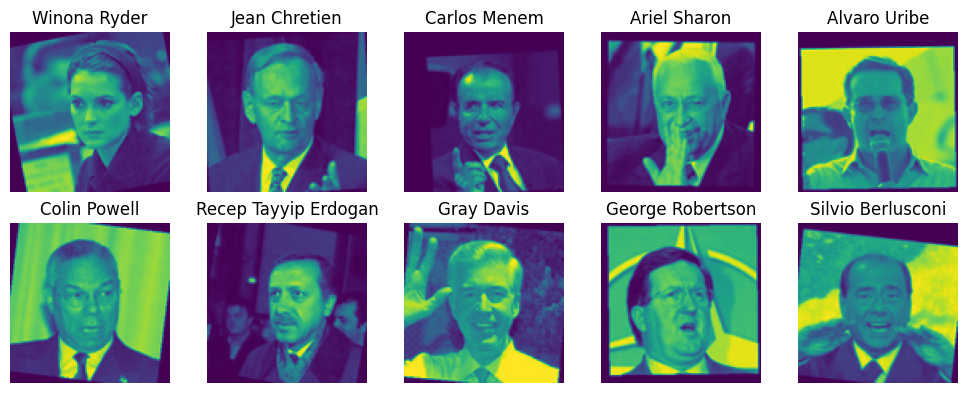

In [9]:
import matplotlib.pyplot as plt
DATA_DIR = "../Dataset/lfw-deepfunneled/lfw-deepfunneled"

faces, target, target_names, paths = fetch_lfw_deep_people(DATA_DIR, resize=0.4, min_faces_per_person=20)

print(faces.shape, target.shape, target_names.shape)
h = faces.shape[1]
w = faces.shape[2]

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(faces[i])
    plt.title(target_names[target[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

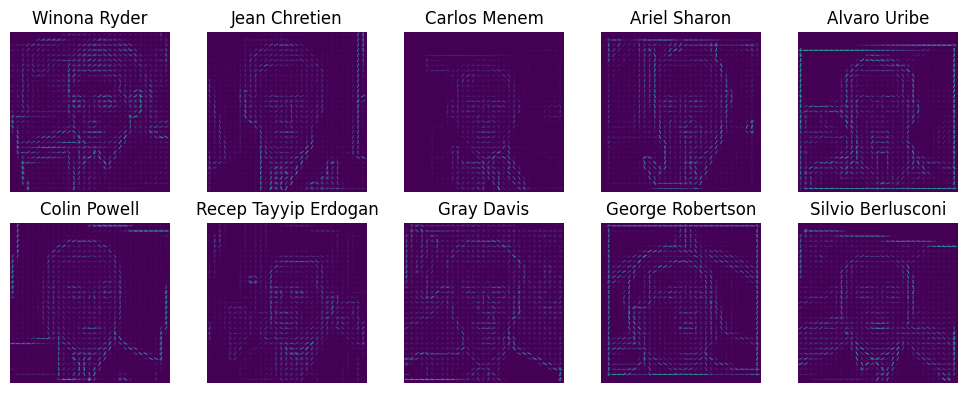

In [10]:
plt.figure(figsize=(10, 4))
for i in range(10):
    hog_f, hog_i = compute_hog(paths[i])
    plt.subplot(2, 5, i + 1)
    plt.imshow(hog_i)
    plt.title(target_names[target[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

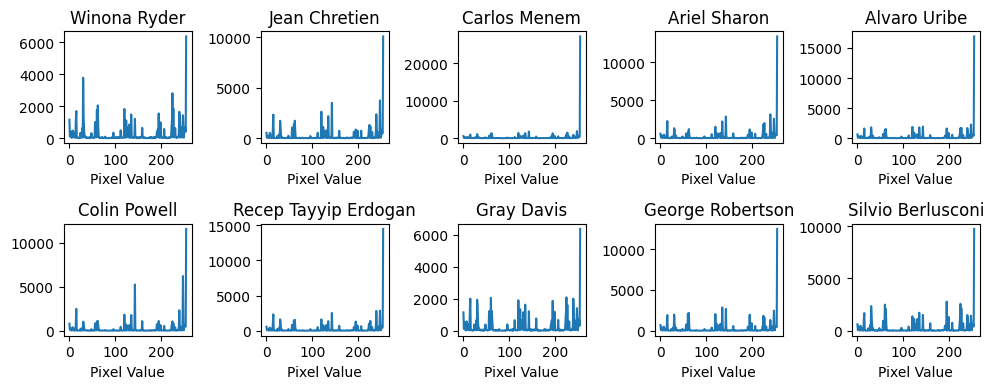

In [11]:
plt.figure(figsize=(10, 4))
for i in range(10):
    hist_lbp = calcLBP(paths[i])
    plt.subplot(2, 5, i + 1)
    plt.plot(hist_lbp)
    plt.title(target_names[target[i]])
    plt.xlabel("Pixel Value")
plt.tight_layout()
plt.show()

In [17]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split

X = faces.reshape(len(faces), -1)
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

pca = PCA()
pca.fit(X_train)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

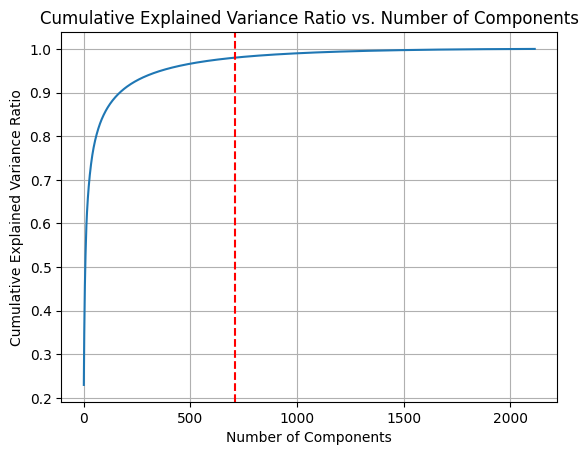

In [13]:
target_variance = 0.98
n_comp = np.argmax(cumulative_variance_ratio >= target_variance) + 1

plt.plot(cumulative_variance_ratio)
plt.axvline(x=n_comp, color='red', linestyle='--', label='n_components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

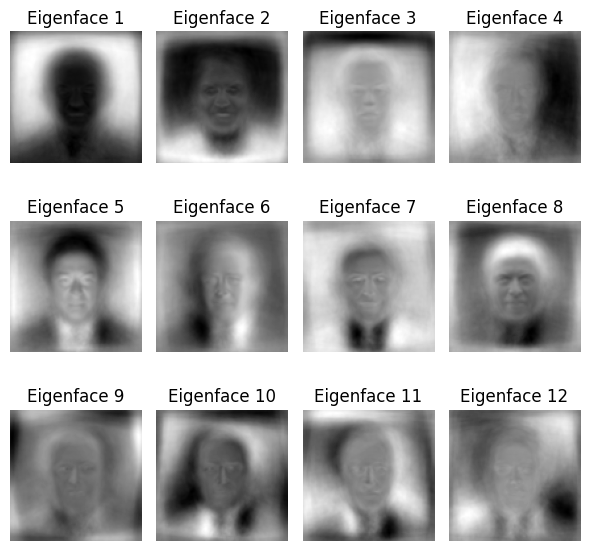

In [16]:
pca = PCA(n_comp)
pca.fit(X_train)
X_train_t = pca.transform(X_train)
X_test_t = pca.transform(X_test)

fig, axes = plt.subplots(3, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape((h, w)), cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_t, y_train)

X_train_t = lda.transform(X_train_t)
X_test_t = lda.transform(X_test_t)

with open("./test.csv", "w") as f:
    for i in range(X_test_t.shape[0]):
        for j in range(X_test_t.shape[1]):
            f.write(f"{X_test_t[i][j]},")
        f.write(f"{y_test[i]}\n")

with open("./train.csv", "w") as f:
    for i in range(X_train_t.shape[0]):
        for j in range(X_train_t.shape[1]):
            f.write(f"{X_train_t[i][j]},")
        f.write(f"{y_train[i]}\n")

print(f"Dimensions of transformed data: {X_train_t.shape}")

Dimensions of transformed data: (2116, 61)


In [24]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

df = pd.read_csv("./train.csv", header=None)
X_train = df.iloc[:, :-1]
y_train = df.iloc[:, -1]

df = pd.read_csv("./test.csv", header=None)
X_test = df.iloc[:, :-1]
y_test = df.iloc[:, -1]

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print(f"Accuracy for Naive Bayes Classifier: {np.mean(gnb.predict(X_test) == y_test)*100:.2f}%")

knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
print(f"Accuracy for K-Nearest Neighbor Classifier: {np.mean(knn.predict(X_test) == y_test)*100:.2f}%")

forest = RandomForestClassifier()
forest.fit(X_train, y_train)
print(f"Accuracy for Random Forest Classifier: {np.mean(forest.predict(X_test) == y_test)*100:.2f}%")

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
print(f"Accuracy for Support Vector Classifier with linear kernel = {np.mean(svm.predict(X_test) == y_test)*100:.2f}%")

Accuracy for Naive Bayes Classifier: 59.65%
Accuracy for K-Nearest Neighbor Classifier: 57.00%
Accuracy for Random Forest Classifier: 56.56%
Accuracy for Support Vector Classifier with linear kernel = 60.42%


In [28]:
import torch

X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.int64))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.int64))

In [55]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, target_names.shape[0])
        )
    def forward(self, x):
        logits = self.layers(x)
        return logits
    
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{20}], Loss: {loss.item()}")

Epoch [1/20], Loss: 0.8476247787475586
Epoch [2/20], Loss: 0.8109166622161865
Epoch [3/20], Loss: 0.174198180437088
Epoch [4/20], Loss: 0.002402795944362879
Epoch [5/20], Loss: 0.0011709085665643215
Epoch [6/20], Loss: 0.006433343980461359
Epoch [7/20], Loss: 0.0019900165498256683
Epoch [8/20], Loss: 0.00020225750631652772
Epoch [9/20], Loss: 1.937146635100362e-06
Epoch [10/20], Loss: 0.013701090589165688
Epoch [11/20], Loss: 0.0020872144959867
Epoch [12/20], Loss: 9.089630111702718e-06
Epoch [13/20], Loss: 0.00017571469652466476
Epoch [14/20], Loss: 2.6910189262707718e-05
Epoch [15/20], Loss: 0.0006246694829314947
Epoch [16/20], Loss: 0.0005621164455078542
Epoch [17/20], Loss: 0.000381205027224496
Epoch [18/20], Loss: 6.1415383243002e-05
Epoch [19/20], Loss: 0.00040770621853880584
Epoch [20/20], Loss: 0.0007792463875375688


In [56]:
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    probabilities = nn.functional.softmax(outputs, dim=1)
    _, predicted = torch.max(probabilities, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f"Accuracy for Neural Network with Cross Entropy Loss as Loss function = {accuracy*100:.2f}%")

Accuracy for Neural Network with Cross Entropy Loss as Loss function = 55.90%
